# Image to Image Translation using Conditional GAN
URL : https://www.tensorflow.org/tutorials/generative/pix2pix?hl=fr

### Importation des bibliothèques

In [1]:
%pip install tensorflow
%pip install --upgrade tensorflow matplotlib ipython

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   --------- ------------------------------ 1.8/8.0 MB 9.1 MB/s eta 0:00:01
   --------------- ------------------------ 3.1/8.0 MB 8.0 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.0 MB 8.2 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.0 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 8.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/820.8 kB ? eta -:--:--
   ---------------------------------------- 820.8/820.8 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.2
    Uninstalling matplotlib-3.9.2:
      Successfully uninstalled matplotlib-3.9.2
  Attempting uninstall: ipython
    Found existing installation: ipython 8.27.0
    Uninstalling ipython-8.27.0:
      Successfully uninstalled ipython-8.27.0
Note: y

In [1]:
import os
import time
import datetime
from PIL import Image

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from IPython import display

from keras import losses
from keras import optimizers
from keras import Sequential, layers, Model

### Chargement des jeux de données

Lien : https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/
1. cityscapes.tar.gz
1. facades.tar.gz
1. maps.tar.gz

In [41]:
#!tar -xvf datasets/cityscapes.tar.gz -C datasets
#!tar -xvf datasets/facades.tar.gz -C datasets
#!tar -xvf datasets/maps.tar.gz -C datasets

x cityscapes/
x cityscapes/train/
x cityscapes/train/17.jpg
x cityscapes/train/234.jpg
x cityscapes/train/2970.jpg
x cityscapes/train/1.jpg
x cityscapes/train/10.jpg
x cityscapes/train/100.jpg
x cityscapes/train/1000.jpg
x cityscapes/train/1001.jpg
x cityscapes/train/1002.jpg
x cityscapes/train/1003.jpg
x cityscapes/train/1004.jpg
x cityscapes/train/1005.jpg
x cityscapes/train/1006.jpg
x cityscapes/train/1007.jpg
x cityscapes/train/1008.jpg
x cityscapes/train/1009.jpg
x cityscapes/train/101.jpg
x cityscapes/train/1010.jpg
x cityscapes/train/1011.jpg
x cityscapes/train/1012.jpg
x cityscapes/train/1013.jpg
x cityscapes/train/1014.jpg
x cityscapes/train/1015.jpg
x cityscapes/train/1016.jpg
x cityscapes/train/1017.jpg
x cityscapes/train/1018.jpg
x cityscapes/train/1019.jpg
x cityscapes/train/102.jpg
x cityscapes/train/1020.jpg
x cityscapes/train/1021.jpg
x cityscapes/train/1022.jpg
x cityscapes/train/1023.jpg
x cityscapes/train/2193.jpg
x cityscapes/train/2194.jpg
x cityscapes/train/2195.j

(256, 512, 3)


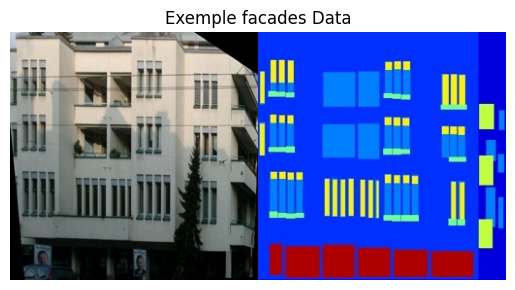

In [2]:
dataset_path = r".\datasets\facades"
image_name = r"train\1.jpg"

image = np.array(Image.open(os.path.join(dataset_path, image_name)))
print(image.shape)
plt.imshow(image)
plt.axis('off')
plt.title(f"Exemple {os.path.basename(dataset_path)} Data")
plt.show()

### Préprocessing des données

In [3]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

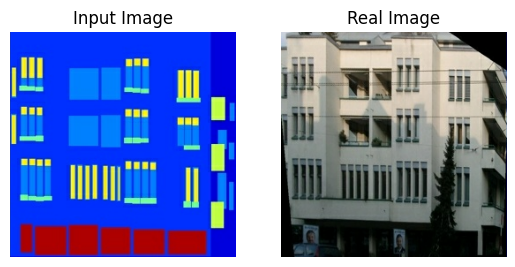

In [4]:
## Charge l'image d'entrée et l'image réelle séparément
def load(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)
    w = tf.shape(image)[1] // 2
    
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

input_im, real_im = load(os.path.join(dataset_path, image_name))

plt.figure()
ax = plt.subplot(1, 2, 1)
ax.imshow(input_im / 255.0)
ax.set_title('Input Image')
ax.axis('off')
ax = plt.subplot(1, 2, 2)
ax.imshow(real_im / 255.0)
ax.set_title('Real Image')
ax.axis('off')
plt.show()

In [5]:
## Redimmensionner, Recadrer, Retourner aléatoirement, Normaliser sur [-1, 1]
def resize(input_image,real_image,height,width):
    input_image = tf.image.resize(input_image, [height,width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image,real_image

def random_crop(input_image,real_image):
    # Superposition des 2 images, ce qui forme un tenseur (2,H,W,3)
    # Ce tenseur contient donc les 2 images empilées en 1 structure
    stacked_image = tf.stack([input_image,real_image], axis=0)

    # Recadrage aléatoire de l'image empilée
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2,IMG_HEIGHT,IMG_WIDTH,3]
    )

    # Le résultat est un tenseur qui contient les 2 images recadrées
    return cropped_image[0],cropped_image[1]

def random_mirroring(input_image,real_image):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
        
    return input_image,real_image


def normalize(input_image,real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image,real_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].


Input_image Shape : (256, 256, 3), Real_image Shape : (256, 256, 3)


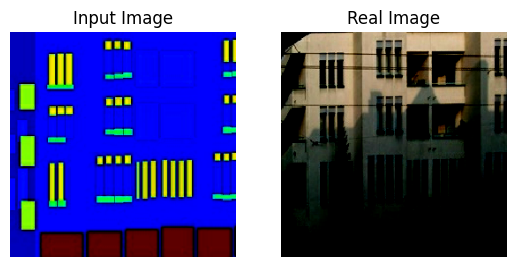

In [6]:
## Preprocessing complet
def preprocessing(input_image,real_image):
    transformations = [
        lambda x, y: resize(x, y, 286, 286),     # Redimensionner
        lambda x, y: random_crop(x, y),          # Recadrer
        lambda x, y: random_mirroring(x, y),     # Retourner aléatoirement
        lambda x, y: normalize(x, y)             # Normaliser sur [-1, 1]
    ]
    
    for transform in transformations:
        input_image, real_image = transform(input_image, real_image)
    
    return input_image, real_image

input_image, real_image = load((os.path.join(dataset_path, image_name)))
input_image, real_image = preprocessing(input_image, real_image)

print(f"Input_image Shape : {input_image.shape}, Real_image Shape : {real_image.shape}")
plt.figure()
ax = plt.subplot(1, 2, 1)
ax.imshow(input_image)
ax.set_title('Input Image')
ax.axis('off')
ax = plt.subplot(1, 2, 2)
ax.imshow(real_image)
ax.set_title('Real Image')
ax.axis('off')
plt.show()

In [7]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = preprocessing(input_image, real_image)
    
    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

### Création d'un pipeline d'entrée

In [8]:
def get_datasets(dataset_path):
    ## Train dataset
    train_dataset = tf.data.Dataset.list_files(os.path.join(dataset_path,'train/*.jpg'))
    train_dataset = train_dataset.map(load_image_train)
    train_dataset = train_dataset.shuffle(BUFFER_SIZE)
    train_dataset = train_dataset.batch(BATCH_SIZE)

    ## Test dataset
    try:
        test_dataset = tf.data.Dataset.list_files(os.path.join(dataset_path,'test/*.jpg'))
    except tf.errors.InvalidArgumentError:
        test_dataset = tf.data.Dataset.list_files(os.path.join(dataset_path,'val/*.jpg'))
    test_dataset = test_dataset.map(load_image_test)
    test_dataset = test_dataset.batch(BATCH_SIZE)

    return train_dataset, test_dataset

train_dataset, test_dataset = get_datasets(dataset_path)

### Création du modèle (U-Net modifié)

In [9]:
## Encodeur (étape down du U-Net)
def downsample(filters, kernel_size, batchnorm=True):
    # L'initialisation aléatoire permet d'éviter que les neurones aient les mêmes valeurs au départ
    initializer = tf.random_normal_initializer(0.,0.02)

    model = Sequential()

    # stride=2 : divise par 2 la taille de l'image de sortie par rapport à l'image d'entrée
    # padding=same : l'image de sortie aura la même taille (ou presque) que l'image d'entrée
    # Ce résultat s'obtient en ajoutant des 0 autour de l'image si nécessaire
    model.add(layers.Conv2D(filters, kernel_size, strides=2, padding="same",
                            kernel_initializer=initializer, use_bias=False))
    
    if batchnorm:
        model.add(layers.BatchNormalization())

    model.add(layers.LeakyReLU())

    return model


## Décoder (étape Up du U-Net)
def upsample(filters, kernel_size, dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)

    model = Sequential()
    model.add(layers.Conv2DTranspose(filters,kernel_size,strides=2,padding="same",
                                     kernel_initializer=initializer,use_bias=False))
    model.add(layers.BatchNormalization())

    if dropout:
        model.add(layers.Dropout(0.5))
    
    model.add(layers.ReLU())

    return model

down_model = downsample(3,4)
x = tf.random.normal([1, 256, 256, 3])
down_result = down_model(x)
print("Downsampling result: ", down_result.shape)

up_model = upsample(3,4)
up_result = up_model(down_result)
print("Upsampling result:", up_result.shape)


Downsampling result:  (1, 128, 128, 3)
Upsampling result: (1, 256, 256, 3)


In [10]:
OUTPUT_CHANNELS = 3

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64,4,batchnorm=False),
        downsample(128,4),
        downsample(256,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4)    
    ]

    up_stack = [
        upsample(512,4, dropout=True),
        upsample(512,4, dropout=True),
        upsample(512,4, dropout=True),
        upsample(512,4),
        upsample(256,4),
        upsample(128,4),
        upsample(64,4)
    ]

    initializer = tf.random_normal_initializer(0,0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, kernel_size=4, strides=2, padding="same",
                                  kernel_initializer=initializer,
                                  activation="tanh")
    
    x = inputs

    # Sous-échantillonnage
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Sur-échantillonnage
    for up, skip in zip(up_stack,skips):
        x = up(x)
        x = layers.Concatenate()([x,skip])

    x = last(x)

    return Model(inputs, outputs=x)

generator = Generator()
x = tf.random.normal([1, 256, 256, 3])
y = generator(x)
print(f"Model Result : {y.shape}")

Model Result : (1, 256, 256, 3)


#### Visualisation de l'architecture du générateur 
Nécessite l'installation de graphviz : https://graphviz.gitlab.io/download/ et de la librairie pydot

In [11]:
#%pip install pydot
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


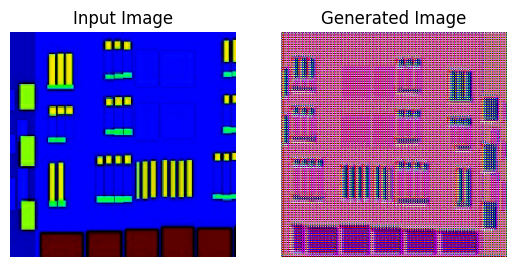

In [12]:
gen_output = generator(input_im[tf.newaxis, ...], training=False)
plt.figure()
ax = plt.subplot(1, 2, 1)
ax.imshow(input_image)
ax.set_title('Input Image')
ax.axis('off')
ax = plt.subplot(1, 2, 2)
ax.imshow(gen_output[0, ...])
ax.set_title('Generated Image')
ax.axis('off')
plt.show()

### Définir la perte du générateur

In [13]:
# Valeur de Lambda décidé par les auteurs de l'article
LAMBDA = 100 
# La perte du générateur est une perte d'entropie croisée
loss_object = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Erreur moyenne absolue
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [14]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)

    input = layers.Input(shape=[256,256,3], name="input_image")
    target = layers.Input(shape=[256,256,3], name="target_image")

    x = layers.concatenate([input,target])

    down1 = downsample(64,4,False)(x)
    down2 = downsample(128,4)(down1)
    down3 = downsample(128,4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)

    conv = layers.Conv2D(512,4,strides=1, kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)    
    
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1,4,strides=1,
                         kernel_initializer=initializer)(zero_pad2)
    
    return Model(inputs=[input,target], outputs=last)

#### Visualisation de l'architecture du discriminateur 
Nécessite l'installation de graphviz : https://graphviz.gitlab.io/download/ et de la librairie pydot

In [15]:
#%pip install pydot
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


### Test du discriminateur

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


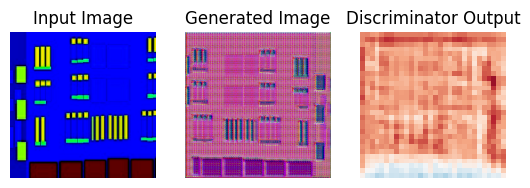

In [16]:
# La forme de la sortie après la dernière couche est (batch_size, 30, 30, 1)
# Chaque patch d'image 30 x 30 de la sortie classe une partie 70 x 70 de l'image d'entrée
disc_out = discriminator([input_im[tf.newaxis,...], gen_output], training=False)

plt.figure()
ax = plt.subplot(1, 3, 1)
ax.imshow(input_image)
ax.set_title('Input Image')
ax.axis('off')
ax = plt.subplot(1, 3, 2)
ax.imshow(gen_output[0, ...])
ax.set_title('Generated Image')
ax.axis('off')
ax = plt.subplot(1, 3, 3)
im =ax.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap="RdBu_r")
ax.set_title('Discriminator Output')
ax.axis("off")
plt.show()

### Définir la perte du discriminateur

In [17]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output),disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

### Définir les optimiseurs et un économiseur de points de contrôle

In [36]:
generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)


checkpoint_dir = "./training_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Générer des images

In [20]:
def generate_images(model, input, target):
    prediction = model(input, training=True)
    
    display_list = [input[0], target[0], prediction[0]]
    title = ["Input Image", "Real Image", "Predicted Image"]

    plt.figure(figsize=(15,15))
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]* 0.5 + 0.5)
        plt.axis("off")
    plt.show()

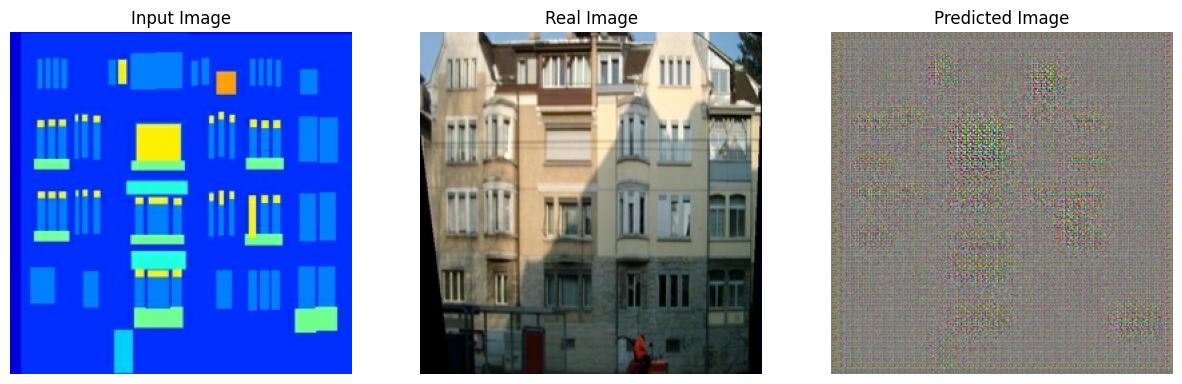

In [27]:
## Résultat avant entrainement
for input, target in test_dataset.take(1):
    generate_images(generator, input, target)

### Entrainement

In [38]:
def train_step(input_image,target,step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        # Évaluation par le discriminateur
        disc_real_output = discriminator([input_image,target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        # Calcul des pertes
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calcul des gradients
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Mise à jour des poids
    generator_optimizer.apply_gradients(zip(generator_gradients, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                            discriminator.trainable_variables))
    
    
    tf.print(
        "Step:", step,
        "| Gen Total Loss:", gen_total_loss,
        "| Gen GAN Loss:", gen_gan_loss,
        "| Gen L1 Loss:", gen_l1_loss,
        "| Disc Loss:", disc_loss
    )

In [39]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        #Affichage périodique des performances
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            if step != 0:
                print(f"Temps pour 1000 itérations : {time.time()-start:.2f} secondes")

            start = time.time()

            generate_images(generator, example_input, example_target)

        train_step(input_image, target, step)

        # Créer un checkpoint toutes les 5000 itérations
        if(step+1)%5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

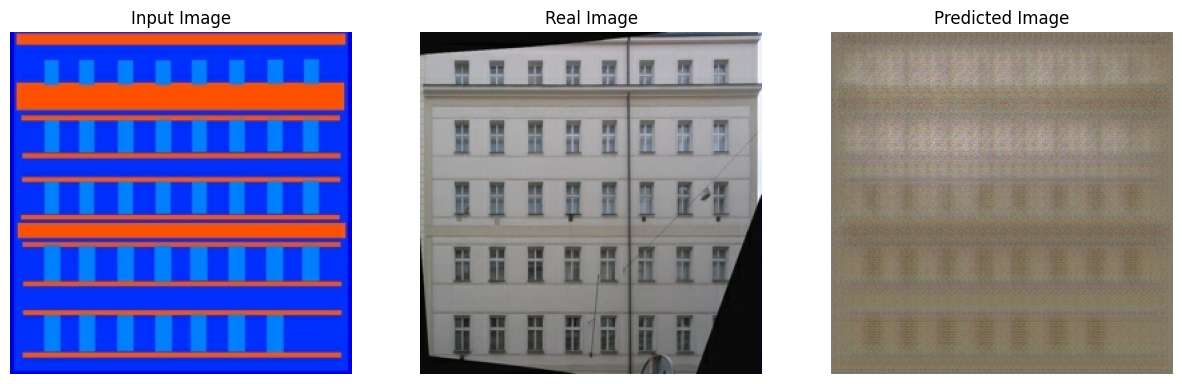

Step: 0 | Gen Total Loss: 40.1333809 | Gen GAN Loss: 0.783343 | Gen L1 Loss: 0.393500358 | Disc Loss: 1.37317383
Step: 1 | Gen Total Loss: 29.8554535 | Gen GAN Loss: 0.772263885 | Gen L1 Loss: 0.290831894 | Disc Loss: 1.39035749
Step: 2 | Gen Total Loss: 37.4394302 | Gen GAN Loss: 0.848543167 | Gen L1 Loss: 0.365908861 | Disc Loss: 1.32994616
Step: 3 | Gen Total Loss: 30.1263981 | Gen GAN Loss: 0.876888812 | Gen L1 Loss: 0.292495102 | Disc Loss: 1.40301144
Step: 4 | Gen Total Loss: 33.6544838 | Gen GAN Loss: 0.880189657 | Gen L1 Loss: 0.327742964 | Disc Loss: 1.46737266
Step: 5 | Gen Total Loss: 32.9471893 | Gen GAN Loss: 0.863627911 | Gen L1 Loss: 0.32083562 | Disc Loss: 1.41419601
Step: 6 | Gen Total Loss: 27.1964512 | Gen GAN Loss: 0.752555907 | Gen L1 Loss: 0.264438957 | Disc Loss: 1.45316172
Step: 7 | Gen Total Loss: 40.6086807 | Gen GAN Loss: 0.790589273 | Gen L1 Loss: 0.398180932 | Disc Loss: 1.78928399
Step: 8 | Gen Total Loss: 27.4236317 | Gen GAN Loss: 0.896099746 | Gen L1 Lo

KeyboardInterrupt: 

In [40]:
fit(train_dataset, test_dataset, steps=40000)

In [40]:
%ls {checkpoint_dir}
## Restaurer le dernier checkpoint de checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

checkpoint                  ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index                ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index                ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index                ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


### Générer des images à l'aide du jeu de test

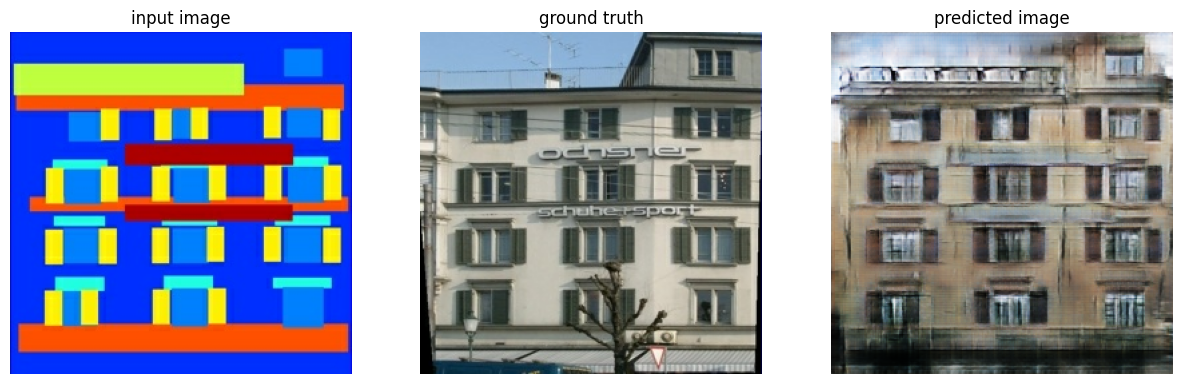

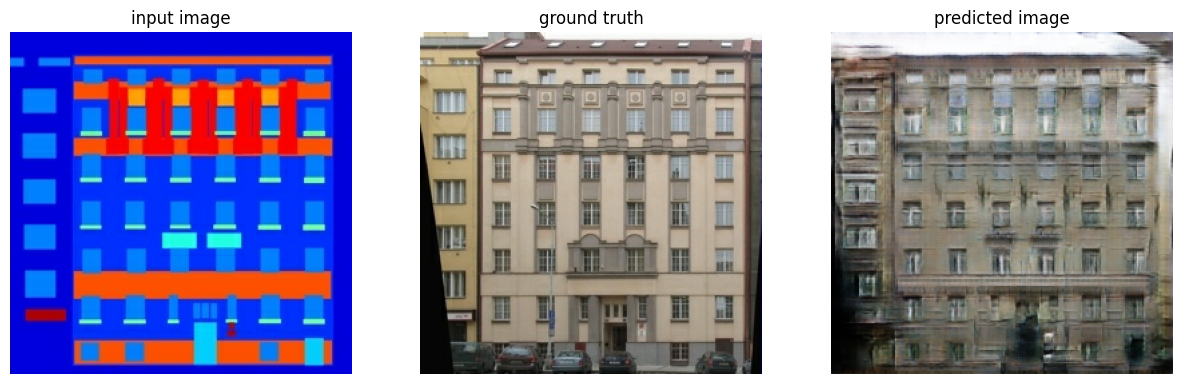

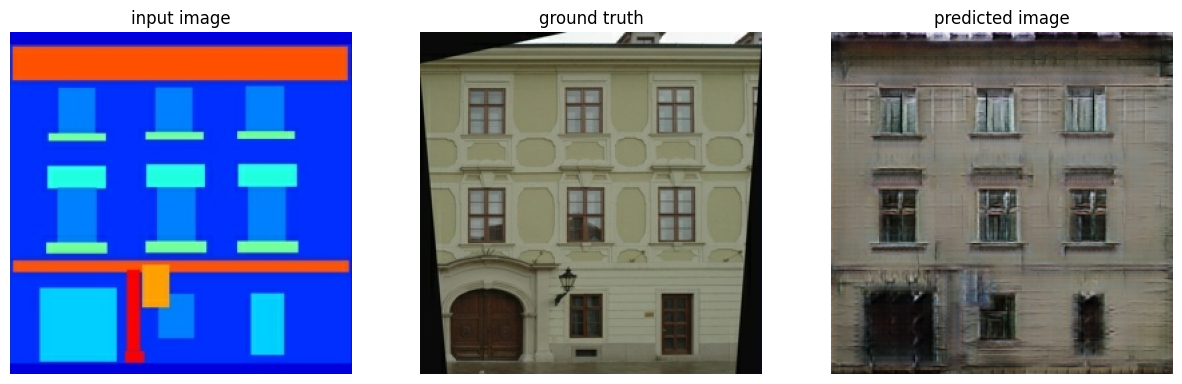

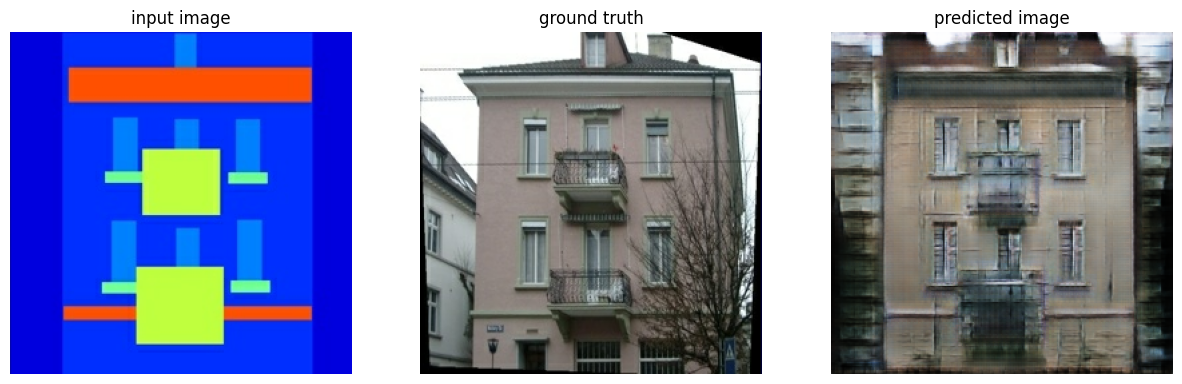

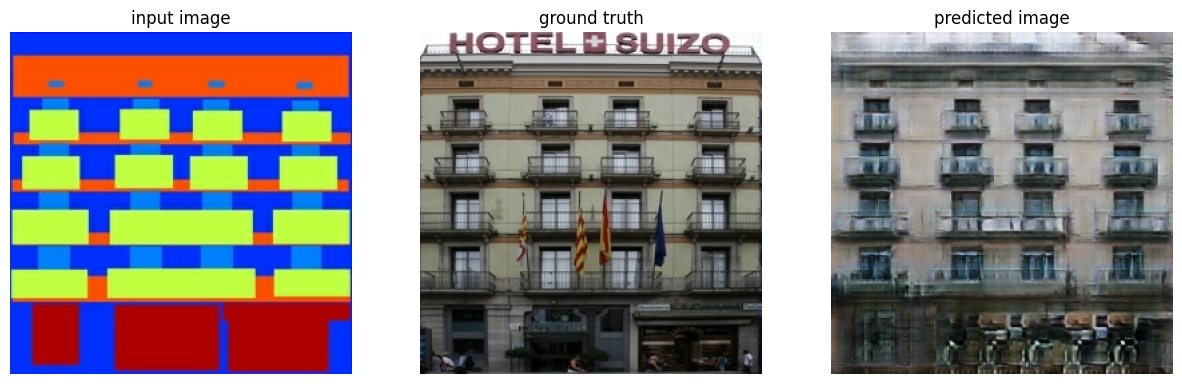

In [41]:
for input, target in test_dataset.take(3):
  generate_images(generator, input, target)